In [21]:
import pandas as pd
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import tldextract
import seaborn as sns
import matplotlib.pyplot as plt

# Đọc dữ liệu
investments = pd.read_csv("data/investments.csv")
companies = pd.read_csv("data/companies.csv")

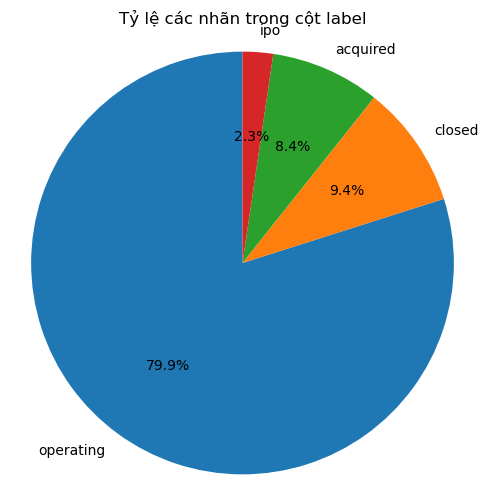

In [22]:
# Vẽ biểu đồ tròn thể hiện tỉ lệ các nhãn trong cột status - label
label_counts = companies['status'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Tỷ lệ các nhãn trong cột label')
plt.axis('equal')  
plt.show()

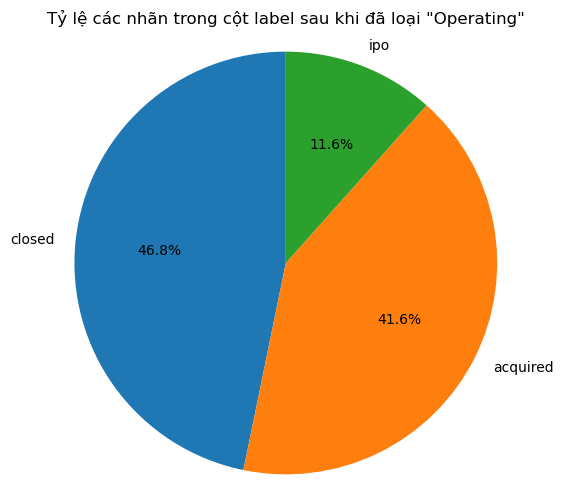

In [23]:
# Xử lý công ty: loại operating, tạo label
companies = companies[companies['status'] != 'operating']

#Vẽ biểu đồ thể hiện tỉ lệ các nhãn status sau khi loại giá trị operating
# Đếm số lượng mỗi nhãn trong cột label
label_counts = companies['status'].value_counts()

# Vẽ biểu đồ tròn
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Tỷ lệ các nhãn trong cột label sau khi đã loại "Operating"')
plt.axis('equal')  
plt.show()

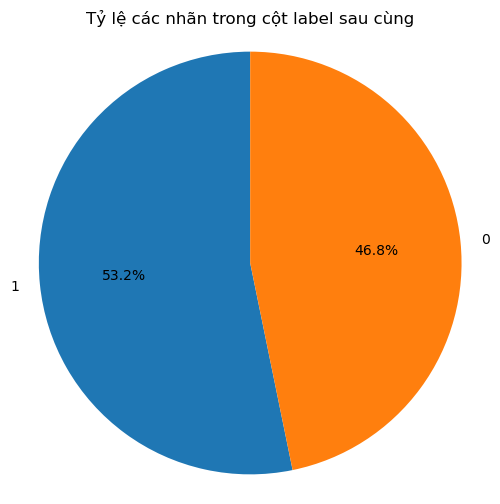

In [24]:
#Tạo nhãn cho dataset, với giá trị 1 thể hiện công ti thành công và 0 là cho trường hợp công ty kinh doanh thất bại
companies['label'] = companies['status'].apply(lambda x: 1 if x in ['ipo', 'acquired'] else (0 if x == 'closed' else 0))

# Đếm số lượng mỗi nhãn trong cột label
label_counts = companies['label'].value_counts()

# Vẽ biểu đồ tròn
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Tỷ lệ các nhãn trong cột label sau cùng')
plt.axis('equal')  
plt.show()

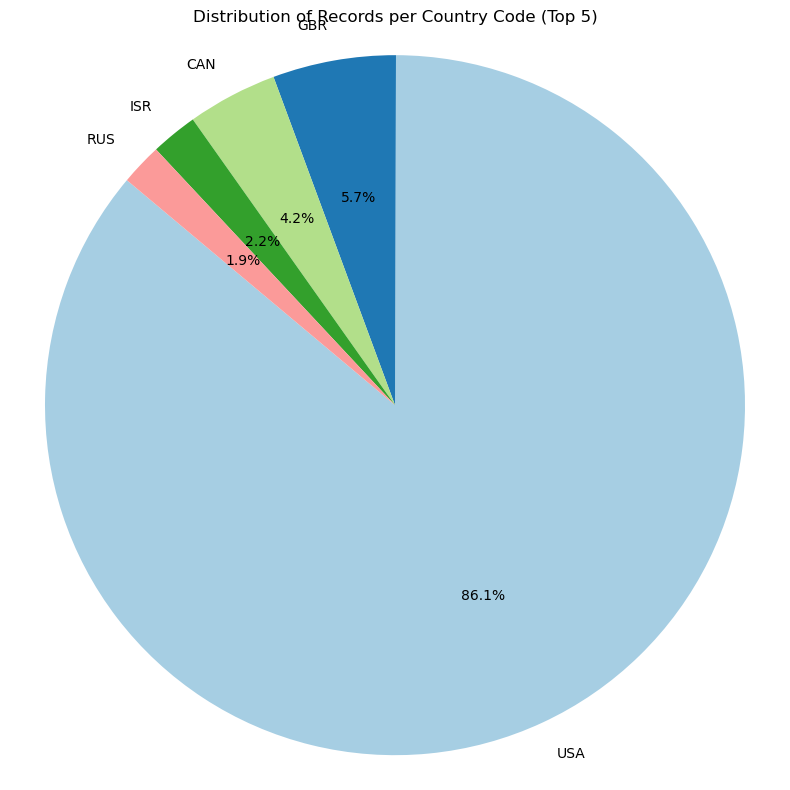

In [25]:
#Vẽ biểu đồ tròn thể hiện sự phân bố công ty theo vị trí địa lý
top_company_country_code = companies['country_code'].value_counts().head(5)

plt.figure(figsize=(8, 8))
plt.pie(
    top_company_country_code,
    labels=top_company_country_code.index,
    autopct='%1.1f%%',    
    startangle=140,
    colors=plt.cm.Paired.colors  
)

plt.title('Distribution of Records per Country Code (Top 5)')
plt.axis('equal')  
plt.tight_layout()
plt.show()

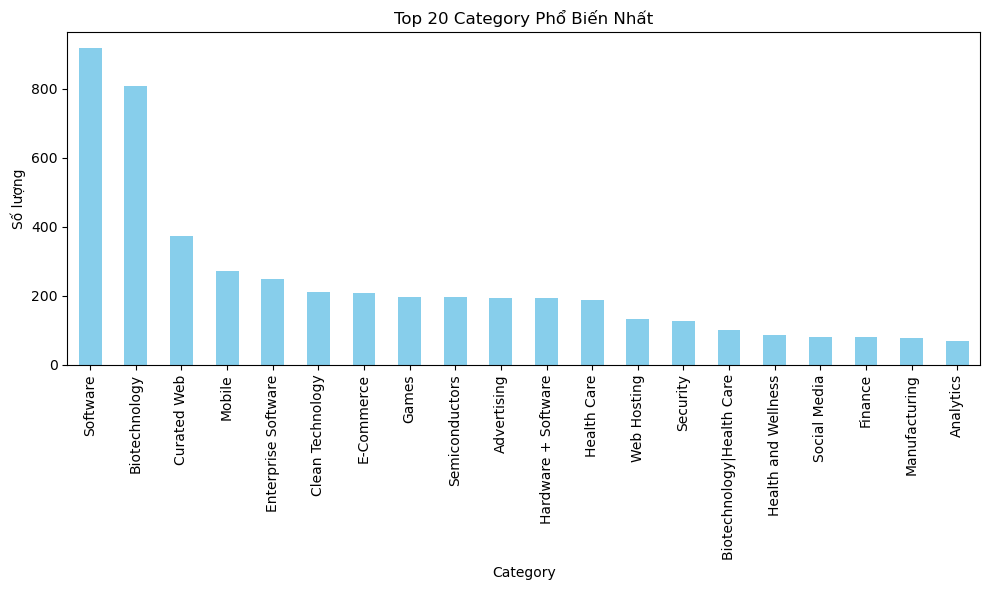

In [26]:
#Vẽ biểu đồ thể hiện các danh mục, phân loại phổ biển nhất
top_categories = companies['category_list'].value_counts().head(20)

plt.figure(figsize=(10, 6))
top_categories.plot(kind='bar', color='skyblue')
plt.title("Top 20 Category Phổ Biến Nhất")
plt.xlabel("Category")
plt.ylabel("Số lượng")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [27]:
# Merge hai bảng company và investment dựa trên perma_link
df = investments.merge(
    companies,
    how='left',
    left_on='company_permalink',
    right_on='permalink',
    suffixes=('', '_company')
)
df = df.dropna(subset=['status'])  # Loại dòng thiếu status

original_columns = set(df.columns)

In [28]:
# 19. num_investors (tạo thêm cột num_investor thể hiện số lượng nhà đầu tư của mối công ty)
investor_counts = df.groupby('company_permalink')['investor_permalink'].nunique().rename("num_investors")
df = df.merge(investor_counts, on='company_permalink', how='left')

In [29]:
#tách tên miền
def extract_domain_suffix(url):
    try:
        ext = tldextract.extract(url)
        return '.' + ext.suffix if ext.suffix else None
    except:
        return None
# tạo cột tên miền
df['company_domain'] = df['homepage_url'].apply(extract_domain_suffix)

In [30]:
df.head(5)

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,investor_country_code,...,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,label,num_investors,company_domain
0,/organization/1-mainstream,1 Mainstream,Apps|Cable|Distribution|Software,USA,CA,SF Bay Area,Cupertino,/organization/sky-2,Sky,NaN,...,CA,SF Bay Area,Cupertino,1.0,2012-03-01,2015-03-17,2015-03-17,1.0,1,.com
1,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/organization/ff-angel-llc,FF Angel LLC,USA,...,WA,Seattle,Seattle,1.0,2009-01-01,2009-05-15,2009-05-15,1.0,3,.com
2,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/organization/true-ventures,True Ventures,USA,...,WA,Seattle,Seattle,1.0,2009-01-01,2009-05-15,2009-05-15,1.0,3,.com
3,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/person/jon-callaghan,Jon Callaghan,USA,...,WA,Seattle,Seattle,1.0,2009-01-01,2009-05-15,2009-05-15,1.0,3,.com
4,/organization/1000memories,1000memories,Curated Web,USA,CA,SF Bay Area,San Francisco,/organization/felicis-ventures,Felicis Ventures,USA,...,CA,SF Bay Area,San Francisco,2.0,2010-07-01,2010-01-01,2011-02-16,1.0,12,.com


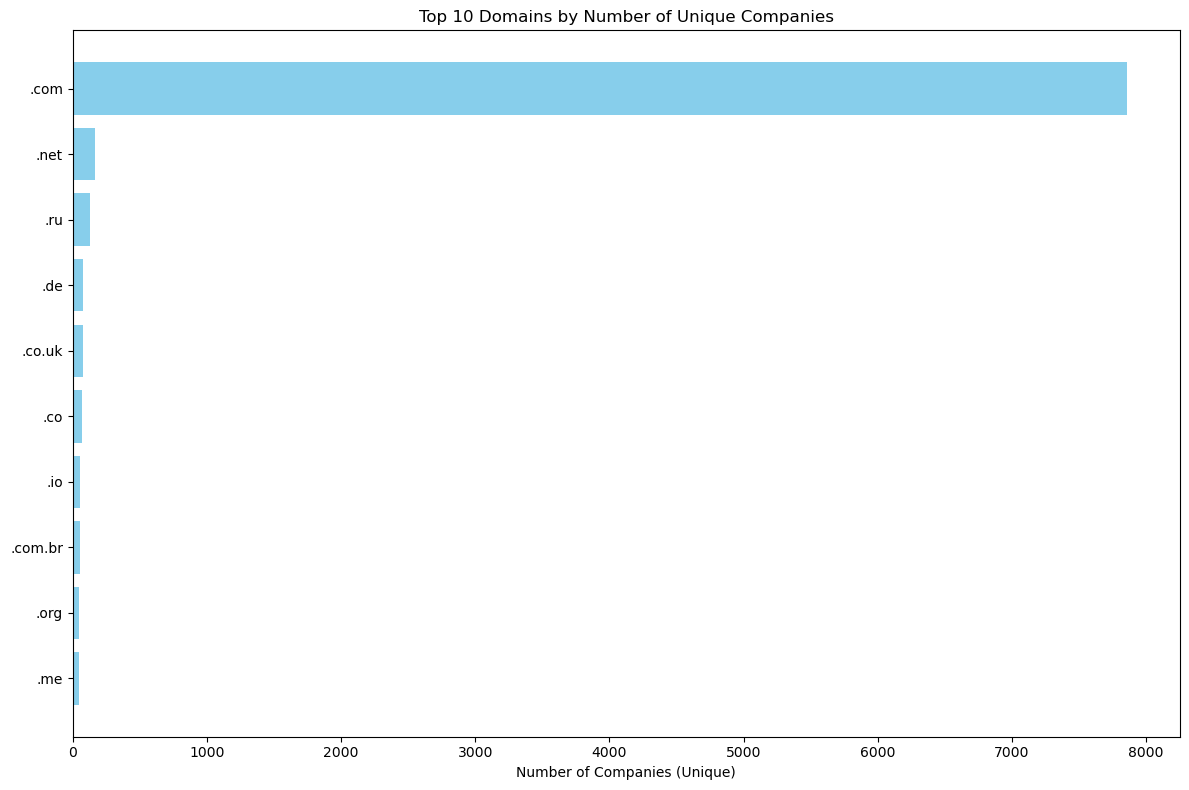

In [31]:
# Tạo sơ đồ thể hiện sự phân bổ tên miền của các công ty trong tập dữ liệu
# Lấy dataframe các công ty không trùng lặp theo company_name, giữ cột domain
unique_companies = df.drop_duplicates(subset='company_name')[['company_name', 'company_domain']]

# Đếm số công ty theo domain
domain_counts = unique_companies['company_domain'].value_counts()

# Lấy top 10 domain nhiều công ty nhất
top_domains = domain_counts.head(10).sort_values(ascending=True)

plt.figure(figsize=(12,8))
plt.barh(top_domains.index, top_domains.values, color='skyblue')

plt.xlabel('Number of Companies (Unique)')
plt.title('Top 10 Domains by Number of Unique Companies')
plt.tight_layout()
plt.show()

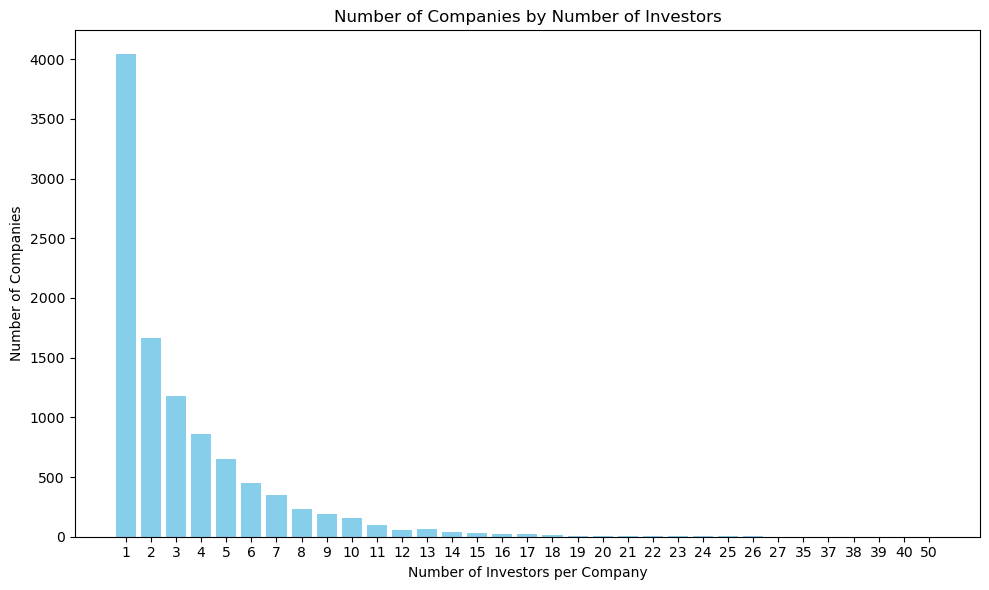

In [32]:
# sơ đồ thể hiện số lượng công ty theo từng số lượng nhà đầu tư
# Lấy các công ty duy nhất
unique_companies = df.drop_duplicates(subset='company_name')[['company_name', 'num_investors']]

# Đếm số công ty theo num_investors
company_counts_by_investor_num = unique_companies['num_investors'].value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.bar(company_counts_by_investor_num.index.astype(str), company_counts_by_investor_num.values, color='skyblue')

plt.xlabel('Number of Investors per Company')
plt.ylabel('Number of Companies')
plt.title('Number of Companies by Number of Investors')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

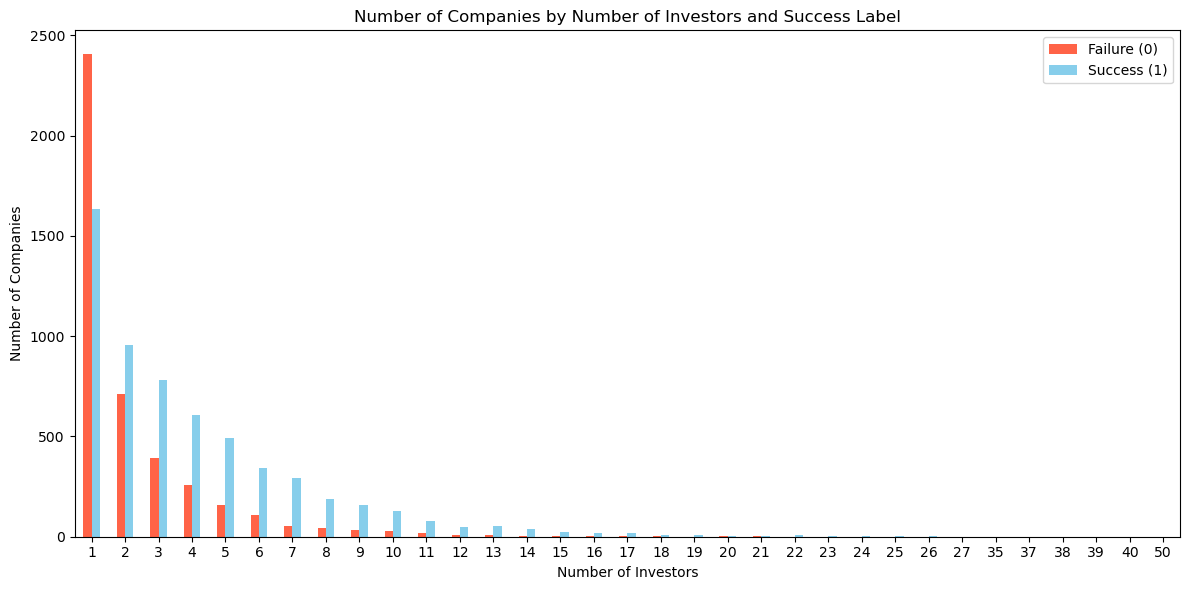

In [33]:
# sơ đồ thể hiện sự phân bổ của công ty thành công và thất bại theo từng số lượng nhà đầu tư
# Lấy các công ty duy nhất
unique_companies = df.drop_duplicates(subset='company_name')[['num_investors', 'label']]

# Đếm số công ty theo num_investors và label
counts = unique_companies.groupby(['num_investors', 'label']).size().unstack(fill_value=0).sort_index()

# Vẽ grouped bar chart
counts.plot(kind='bar', figsize=(12,6), color=['tomato', 'skyblue'])

plt.xlabel('Number of Investors')
plt.ylabel('Number of Companies')
plt.title('Number of Companies by Number of Investors and Success Label')
plt.xticks(rotation=0)
plt.legend(['Failure (0)', 'Success (1)'])
plt.tight_layout()
plt.show()

In [34]:
# == Investor Features ==

# 1-14. investor_name (one-hot 14 keywords)
all_investor_names = df['investor_name'].dropna().tolist()
all_words = []
for name in all_investor_names:
    words = re.findall(r'\b\w+\b', name.lower())
    all_words.extend(words)
word_freq = Counter(all_words)
top_14_keywords = [word for word, count in word_freq.most_common(14)]

df['investor_keywords'] = df['investor_name'].fillna('').apply(
    lambda name: [kw for kw in top_14_keywords if kw in name.lower()]
)
for kw in top_14_keywords:
    df[f'investor_{kw}'] = df['investor_keywords'].apply(lambda kws: int(kw in kws))
df.drop(columns=['investor_keywords'], inplace=True)

# 15. raised_amount_usd
df['raised_amount_usd'] = df['raised_amount_usd'].fillna(0)

# 16. raised_amount_m (Million)
df['raised_amount_m'] = df['raised_amount_usd'] / 1e6

# 17. raised_amount_b (Billion)
df['raised_amount_b'] = df['raised_amount_usd'] / 1e9

# 18. raised_amount_k (K)
df['raised_amount_k'] = df['raised_amount_usd'] / 1e3

# 19. num_investors - Đã xử lý bên trên lúc vẽ sơ đồ
#investor_counts = df.groupby('company_permalink')['investor_permalink'].nunique().rename("num_investors")
#df = df.merge(investor_counts, on='company_permalink', how='left')

# 20-32. funding_round_type (one-hot 13)
df['funding_round_type'] = df['funding_round_type'].fillna('unknown')
top_13_round_types = df['funding_round_type'].value_counts().nlargest(13).index.tolist()
for round_type in top_13_round_types:
    df[f'funding_type_{round_type}'] = (df['funding_round_type'] == round_type).astype(int)

# 33-38. funding_round_code (one-hot 6)
top_6_codes = df['funding_round_code'].value_counts().nlargest(6).index.tolist()
for code in top_6_codes:
    df[f'funding_code_{code}'] = (df['funding_round_code'] == code).astype(int)

# 39. success_rate
success_rate = df.groupby('investor_permalink')['label'].mean().rename('success_rate')
df = df.merge(success_rate, on='investor_permalink', how='left')

# 40. failure_rate
failure_rate = df.groupby('investor_permalink')['label'].apply(lambda x: 1 - x.mean()).rename('failure_rate')
df = df.merge(failure_rate, on='investor_permalink', how='left')

# 41. success_amount
# Tạo bản sao để tránh ảnh hưởng khi merge
original_df = df.copy()
successful_df = original_df[original_df['label'] == 1]
success_amount = successful_df.groupby('investor_permalink')['raised_amount_usd'].sum().rename("success_amount")
df = df.merge(success_amount, on='investor_permalink', how='left')

# 42. fail_amount
failed_df = original_df[original_df['label'] == 0]
fail_amount = failed_df.groupby('investor_permalink')['raised_amount_usd'].sum().rename("fail_amount")
df = df.merge(fail_amount, on='investor_permalink', how='left')

# 43. total_amount
df['total_amount'] = df['success_amount'] + df['fail_amount']

# 44. avg_funding_per_investor
avg_funding = df.groupby('investor_permalink')['raised_amount_usd'].mean().rename("avg_funding_per_investor")
df = df.merge(avg_funding, on='investor_permalink', how='left')

# 45. num_of_success_companies
num_success = successful_df.groupby('investor_permalink')['company_permalink'].nunique().rename("num_of_success_companies")
df = df.merge(num_success, on='investor_permalink', how='left')

# 46. num_of_failed_companies
num_failed = failed_df.groupby('investor_permalink')['company_permalink'].nunique().rename("num_of_failed_companies")
df = df.merge(num_failed, on='investor_permalink', how='left')

# 47. total_amount = 43
df['total_amount'] = df['success_amount'].fillna(0) + df['fail_amount'].fillna(0)

# 48-50. funded_at year/month/day
df['funded_at'] = pd.to_datetime(df['funded_at'], errors='coerce')
epoch = pd.Timestamp("1970-01-01")
df['funded_at_year'] = (df['funded_at'].dt.year - 1970).astype('Int64')
df['funded_at_month'] = ((df['funded_at'].dt.year - 1970) * 12 + df['funded_at'].dt.month).astype('Int64')
df['funded_at_day'] = ((df['funded_at'] - epoch) // pd.Timedelta('1D')).astype('Int64')

In [35]:
# == Business Features ==
# Đã xử lý lúc vẽ sơ đồ
# 51-55. company_domain (one-hot 5)
#def extract_domain_suffix(url):
#    try:
 #       ext = tldextract.extract(url)
  #      return '.' + ext.suffix if ext.suffix else None
 #   except:
  #      return None

#df['company_domain'] = df['homepage_url'].apply(extract_domain_suffix)
top_5_domains = df['company_domain'].dropna().value_counts().nlargest(5).index.tolist()
for domain in top_5_domains:
    df[f'domain_{domain.replace(".", "")}'] = df['company_domain'].apply(lambda x: int(x == domain))

# 56-535. business_sector (CountVectorizer 480 dimensions)
df['category_list'] = df['category_list'].fillna('unknown')
vectorizer = CountVectorizer(binary=True, max_features=480, token_pattern=r'[^|]+')
category_matrix = vectorizer.fit_transform(df['category_list'])
category_df = pd.DataFrame(category_matrix.toarray(), columns=[f'sector_{tag.strip()}' for tag in vectorizer.get_feature_names_out()])
category_df.index = df.index
df = pd.concat([df, category_df], axis=1)

# 536-542. country_code (one-hot 7)
top_countries = df['country_code'].value_counts().nlargest(7).index.tolist()
for country in top_countries:
    df[f'country_{country}'] = (df['country_code'] == country).astype(int)

# 543-546. funding_total_usd + các đơn vị
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'], errors='coerce').fillna(0)
df['funding_total_m'] = df['funding_total_usd'] / 1e6
df['funding_total_b'] = df['funding_total_usd'] / 1e9
df['funding_total_k'] = df['funding_total_usd'] / 1e3

# 547. company_age
df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')
current_year = pd.to_datetime('today').year
df['company_age'] = current_year - df['founded_at'].dt.year

# 548-550. avg_funding_duration_per_round và funding_duration (days, months, years)
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')
df['last_funding_at'] = pd.to_datetime(df['last_funding_at'], errors='coerce')
df['funding_rounds'] = df['funding_rounds'].fillna(1)
df['funding_duration_days'] = (df['last_funding_at'] - df['first_funding_at']).dt.days.clip(lower=0).fillna(0)
df['avg_funding_duration_per_round'] = df['funding_duration_days'] / df['funding_rounds']

funding_timespan = df.groupby('company_permalink')['funded_at'].agg(['min', 'max']).rename(columns={'min': 'first_funding', 'max': 'last_funding'})
funding_timespan['funding_duration_days'] = (funding_timespan['last_funding'] - funding_timespan['first_funding']).dt.days
funding_timespan['funding_duration_months'] = funding_timespan['funding_duration_days'] / 30
funding_timespan['funding_duration_years'] = funding_timespan['funding_duration_days'] / 365
df = df.merge(funding_timespan[['funding_duration_days', 'funding_duration_months', 'funding_duration_years']], left_on='company_permalink', right_index=True, how='left')

# 551-553. founded_at day/month/year
df['founded_at_year'] = (df['founded_at'].dt.year - 1970).astype('Int64')
df['founded_at_month'] = ((df['founded_at'].dt.year - 1970) * 12 + df['founded_at'].dt.month).astype('Int64')
df['founded_at_day'] = ((df['founded_at'] - epoch) // pd.Timedelta('1D')).astype('Int64')

# 554-559. first_funding và last_funding (day/month/year)
df['first_funding_year'] = (df['first_funding_at'].dt.year - 1970).astype('Int64')
df['first_funding_month'] = ((df['first_funding_at'].dt.year - 1970) * 12 + df['first_funding_at'].dt.month).astype('Int64')
df['first_funding_day'] = ((df['first_funding_at'] - epoch) // pd.Timedelta('1D')).astype('Int64')
df['last_funding_year'] = (df['last_funding_at'].dt.year - 1970).astype('Int64')
df['last_funding_month'] = ((df['last_funding_at'].dt.year - 1970) * 12 + df['last_funding_at'].dt.month).astype('Int64')
df['last_funding_day'] = ((df['last_funding_at'] - epoch) // pd.Timedelta('1D')).astype('Int64')

# 560. funding_rounds_encoded
funding_rounds_grouped = {i: 'Group_'+str(min(i,7)) for i in range(1, 19)}
df['funding_rounds_group'] = df['funding_rounds'].map(funding_rounds_grouped)
le = LabelEncoder()
df['funding_rounds_encoded'] = le.fit_transform(df['funding_rounds_group'].fillna('Group_7'))

In [36]:
# == Market Features ==

# 561-563. top_past_sector, top_current_sector, top_future_sector
def get_top_sectors(df_range, top_k=5):
    all_tags = df_range['category_list'].dropna().str.split('|').sum()
    counter = Counter(all_tags)
    return set([sector for sector, _ in counter.most_common(top_k)])

past_df = df[df['founded_at'].dt.year < 1990]
current_df = df[(df['founded_at'].dt.year >= 1990) & (df['founded_at'].dt.year <= 1994)]
future_df = df[df['founded_at'].dt.year > 1994]

top_past_sectors = get_top_sectors(past_df)
top_current_sectors = get_top_sectors(current_df)
top_future_sectors = get_top_sectors(future_df)

def count_matching_top_sectors(sector_str, top_set):
    if pd.isna(sector_str):
        return 0
    sectors = set(sector_str.split('|'))
    return len(sectors & top_set)

df['top_past_sector'] = df['category_list'].apply(lambda x: count_matching_top_sectors(x, top_past_sectors))
df['top_current_sector'] = df['category_list'].apply(lambda x: count_matching_top_sectors(x, top_current_sectors))
df['top_future_sector'] = df['category_list'].apply(lambda x: count_matching_top_sectors(x, top_future_sectors))

# 564. funding_frequency
all_sectors = df['category_list'].dropna().str.split('|').sum()
sector_counts = Counter(all_sectors)
total_companies = len(df)

def calculate_funding_frequency(row):
    if pd.isna(row):
        return 0
    sectors = row.split('|')
    frequencies = [sector_counts[sector] / total_companies for sector in sectors]
    return sum(frequencies) / len(sectors)

df['funding_frequency'] = df['category_list'].apply(calculate_funding_frequency)

In [37]:
# --- Chọn các cột mới thuộc Investor, Business, Market Features ---

# Xác định các cột mới (so với original_columns ban đầu)
new_columns = [col for col in df.columns if col not in original_columns or col == 'label' or col == 'raised_amount_usd' or col == 'funding_total_usd']

# Tạo df mới chỉ chứa các cột cần thiết
final_df = df[new_columns]



In [38]:
# Xóa các dòng có missing values
final_df = final_df.dropna()

# Xóa các dòng không dùng trong dữ liệu ( dữ liệu này không dùng, df lấy dư nên drop)
final_df.drop('company_domain', axis=1, inplace=True)
final_df.drop('funding_duration_days_y', axis=1, inplace=True)
final_df.drop('funding_rounds_group', axis=1, inplace=True)
final_df = final_df.rename(columns={'funding_duration_days_x': 'funding_duration_days'}) # code đặt tên nhầm, rename thui kh có gì cả



In [39]:
# Kiểm tra các cột có giá trị null trong final_df
null_columns = final_df.columns[final_df.isnull().any()].tolist()

# Hiển thị các cột có giá trị null
if null_columns:
    print("Các cột có giá trị null:", null_columns)
else:
    print("Không có cột nào có giá trị null.")

Không có cột nào có giá trị null.


In [40]:
final_df.head(10)
final_df.info()
final_df.label.value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 24463 entries, 1 to 44470
Columns: 565 entries, raised_amount_usd to funding_frequency
dtypes: Int64(12), float64(23), int32(27), int64(503)
memory usage: 103.4 MB


label
1.0    19662
0.0     4801
Name: count, dtype: int64

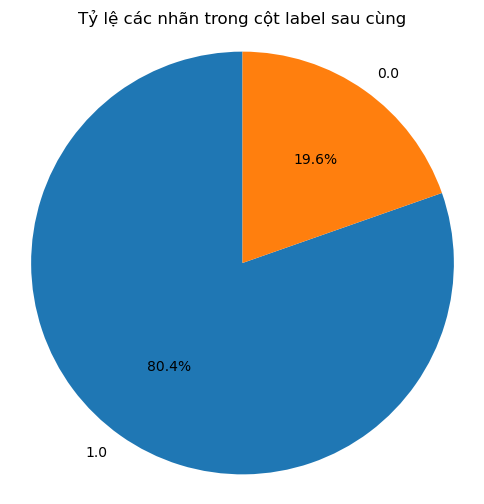

In [41]:
# Đếm số lượng mỗi nhãn trong cột label
label_counts = final_df['label'].value_counts()

# Vẽ biểu đồ tròn
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Tỷ lệ các nhãn trong cột label sau cùng')
plt.axis('equal')  
plt.show()

In [42]:
# Xuất ra file CSV
final_df.to_csv('final_features_full.csv', index=False)

print(f"Xuất thành công {final_df.shape[0]} dòng và {final_df.shape[1]} cột vào 'final_features_full.csv'.")

Xuất thành công 24463 dòng và 565 cột vào 'final_features_full.csv'.
